## Main Code

In [16]:
import sys, os
import requests
import numpy as np
import pandas as pd
import pygrib
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from mpl_toolkits.basemap import Basemap, addcyclic
from datetime import datetime
import psycopg2
from sqlalchemy import create_engine


%matplotlib inline

In [17]:
# setup to download grib files from RDA archive

try:
    import getpass
    input = getpass.getpass
except:
    try:
        input = raw_input
    except:
        pass

In [18]:
# user specific data to login

pswd = input('password:')
values = {'email' : 'nandlalm@student.unimelb.edu.au', 'passwd' : pswd, 'action' : 'login'}
login_url = 'https://rda.ucar.edu/cgi-bin/login'

In [19]:
ret = requests.post(login_url, data=values)
if ret.status_code != 200:
    print('Bad Authentication')
    print(ret.text)
    exit(1)

In [23]:
# bounding box for Australia

min_lat = -43.835
max_lat = -9.796    
min_lon = 112.500
max_lon = 154.688


In [24]:
# file path on RDA catalogue

dspath = 'https://rda.ucar.edu/data/ds083.2/'

In [25]:
# destinantion path

save_dir = '/pollensource/gfs_archive/'

In [26]:
# # ['grib2/2008/2008.01/fnl_20080101_12_00.grib2']
# filelist = []
# for timestep in ['00', '06', '12', '18']:
#     for year in range(2000, 2001):
#         for month in range(1,3):
#             for day in range(1,2):
            
#                 fullday = str(year) + str(month).zfill(2) + str(day).zfill(2)
#                 filename = 'grib1/{}/{}.{:02d}/fnl_{}_{}_00.grib1'.format(year, year, month, fullday, timestep)
#                 filelist.append(filename)
#             print(filelist)

In [27]:
# filelist= ['grib2/2020/2020.07/fnl_20200701_06_00.grib2']
# mainDF = None


In [28]:
# filter data for Australia

def filterAus(file):
    lat_filter = (file["lat"] >= min_lat) & (file["lat"] <= max_lat)
    lon_filter = (file["lon"] >= min_lon) & (file["lon"] <= max_lon)
    filtered = file.loc[lat_filter & lon_filter]
    return filtered.reset_index(drop=True)


In [29]:
# aggregate the hourly data and create variables

def aggregateData9am(dataf):

    grouped_t = dataf.groupby(['coord']).agg({'t': ['mean', 'min', 'max', np.std]})
    grouped_t.columns = ['t_mean_9am', 't_min_9am', 't_max_9am', 't_sd_9am']
    grouped_t = grouped_t.reset_index()

    grouped_t_2m = dataf.groupby(['coord']).agg({'t_2m': ['mean', 'min', 'max', np.std]})
    grouped_t_2m.columns = ['t_2m_mean_9am', 't_2m_min_9am', 't_2m_max_9am', 't_2m_sd_9am']
    grouped_t_2m = grouped_t_2m.reset_index()
    
    grouped_msl = dataf.groupby(['coord']).agg({'msl': ['mean', 'min', 'max', np.std]})
    grouped_msl.columns = ['msl_mean_9am', 'msl_min_9am', 'msl_max_9am', 'msl_sd_9am']
    grouped_msl = grouped_msl.reset_index()

    grouped_hum_atmos = dataf.groupby(['coord']).agg({'hum_atmos': ['mean', 'min', 'max', np.std]})
    grouped_hum_atmos.columns = ['hum_atmos_mean_9am', 'hum_atmos_min_9am', 'hum_atmos_max_9am', 'hum_atmos_sd_9am']
    grouped_hum_atmos = grouped_hum_atmos.reset_index()

    grouped_u_10m = dataf.groupby(['coord']).agg({'u_10m': ['mean', 'min', 'max', np.std]})
    grouped_u_10m.columns = ['u_10m_mean_9am', 'u_10m_min_9am', 'u_10m_max_9am', 'u_10m_sd_9am']
    grouped_u_10m = grouped_u_10m.reset_index()

    grouped_v_10m = dataf.groupby(['coord']).agg({'v_10m': ['mean', 'min', 'max', np.std]})
    grouped_v_10m.columns = ['v_10m_mean_9am', 'v_10m_min_9am', 'v_10m_max_9am', 'v_10m_sd_9am']
    grouped_v_10m = grouped_v_10m.reset_index()

    grouped_pwat = dataf.groupby(['coord']).agg({'pwat': ['mean', 'min', 'max', np.std]})
    grouped_pwat.columns = ['pwat_mean_9am', 'pwat_min_9am', 'pwat_max_9am', 'pwat_sd_9am']
    grouped_pwat = grouped_pwat.reset_index()

    agg_data = grouped_t.merge(grouped_t_2m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_msl, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_hum_atmos, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_u_10m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_v_10m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_pwat, how = 'left', on = 'coord')

    dateval = min(dataf.date.unique())
    agg_data['date'] = dateval
    


    return agg_data

In [30]:
# aggregate the hourly data and create variables

def aggregateData4pm(dataf):

    grouped_t = dataf.groupby(['coord']).agg({'t': ['mean', 'min', 'max', np.std]})
    grouped_t.columns = ['t_mean_4pm', 't_min_4pm', 't_max_4pm', 't_sd_4pm']
    grouped_t = grouped_t.reset_index()

    grouped_t_2m = dataf.groupby(['coord']).agg({'t_2m': ['mean', 'min', 'max', np.std]})
    grouped_t_2m.columns = ['t_2m_mean_4pm', 't_2m_min_4pm', 't_2m_max_4pm', 't_2m_sd_4pm']
    grouped_t_2m = grouped_t_2m.reset_index()

    grouped_msl = dataf.groupby(['coord']).agg({'msl': ['mean', 'min', 'max', np.std]})
    grouped_msl.columns = ['msl_mean_4pm', 'msl_min_4pm', 'msl_max_4pm', 'msl_sd_4pm']
    grouped_msl = grouped_msl.reset_index()

    grouped_hum_atmos = dataf.groupby(['coord']).agg({'hum_atmos': ['mean', 'min', 'max', np.std]})
    grouped_hum_atmos.columns = ['hum_atmos_mean_4pm', 'hum_atmos_min_4pm', 'hum_atmos_max_4pm', 'hum_atmos_sd_4pm']
    grouped_hum_atmos = grouped_hum_atmos.reset_index()

    grouped_u_10m = dataf.groupby(['coord']).agg({'u_10m': ['mean', 'min', 'max', np.std]})
    grouped_u_10m.columns = ['u_10m_mean_4pm', 'u_10m_min_4pm', 'u_10m_max_4pm', 'u_10m_sd_4pm']
    grouped_u_10m = grouped_u_10m.reset_index()

    grouped_v_10m = dataf.groupby(['coord']).agg({'v_10m': ['mean', 'min', 'max', np.std]})
    grouped_v_10m.columns = ['v_10m_mean_4pm', 'v_10m_min_4pm', 'v_10m_max_4pm', 'v_10m_sd_4pm']
    grouped_v_10m = grouped_v_10m.reset_index()

    grouped_pwat = dataf.groupby(['coord']).agg({'pwat': ['mean', 'min', 'max', np.std]})
    grouped_pwat.columns = ['pwat_mean_4pm', 'pwat_min_4pm', 'pwat_max_4pm', 'pwat_sd_4pm']
    grouped_pwat = grouped_pwat.reset_index()


    agg_data = grouped_t.merge(grouped_t_2m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_msl, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_hum_atmos, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_u_10m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_v_10m, how = 'left', on = 'coord')
    agg_data = agg_data.merge(grouped_pwat, how = 'left', on = 'coord')
    dateval = min(dataf.date.unique())
    agg_data['date'] = dateval
    


    return agg_data

In [31]:
# extract relevant data from the grib files

def getData(filename):

    fileAddress = '/pollensource/gfs_archive/' + filename
    myfile = pygrib.open(fileAddress)

    # get surface level temperature data
    grb_temp = myfile.select(shortName='t', typeOfLevel = 'surface')
    lat = grb_temp[0].latitudes
    lon = grb_temp[0].longitudes
    vals = grb_temp[0].values.reshape(lon.shape[0],)
    date = grb_temp[0].validDate
    
    df = pd.DataFrame(None, index=range(65160), columns=['datetime', 'lat', 'lon', 't'])  # range hard-coded for now
    df['datetime'] = date
    df['lat'] = lat
    df['lon'] = lon
    df['t'] = vals
    df['date'] = pd.to_datetime(df['datetime']).dt.date
    
    # get 2m level temperature data
    grb_temp_2m = myfile.select(shortName='2t')
    vals_2t = grb_temp_2m[0].values.reshape(lon.shape[0],)
    df['t_2m'] = vals_2t

    # get mean sea level pressure
    grb_msl = myfile.select(shortName='prmsl')
    vals_msl = grb_msl[0].values.reshape(lon.shape[0],)
    df['msl'] = vals_msl

    # get 10m u component of wind
    grb_10u = myfile.select(shortName='10u')
    vals_10u = grb_10u[0].values.reshape(lon.shape[0],)
    df['u_10m'] = vals_10u

    # get 10m v component of wind
    grb_10v = myfile.select(shortName='10v')
    vals_10v = grb_10v[0].values.reshape(lon.shape[0],)
    df['v_10m'] = vals_10v

    # get the relative humidity
    grb_r = myfile.select(shortName='r', typeOfLevel = 'atmosphereSingleLayer')
    vals_r = grb_r[0].values.reshape(lon.shape[0],)
    df['hum_atmos'] = vals_r

    # get precipitable water
    grb_pwat = myfile.select(shortName='pwat')
    vals_pwat = grb_pwat[0].values.reshape(lon.shape[0],)
    df['pwat'] = vals_pwat

    data  = filterAus(df)
    # print(data)
    # data['coord'] = (data['lon'], data['lat'])
    data['coord'] = list(zip(data.lon, data.lat))
    data.coord = data.coord.astype(str)

    data = data.drop(['lat', 'lon'], axis = 1)

    return data



In [32]:
# add df data to db

def addToDb(df):

    databse = 'gfs_data'
    user = 'gfs'
    password = 'pollenmelb'
    host="127.0.0.1"

    conn_string = f"postgresql://{user}:{password}@{host}/{databse}"
    engine = create_engine(conn_string)
    
    if len(df.columns)<10:
        table_name = 'weatherRaw'
    else:
        table_name = 'weather'

    if_exists = 'append'

    #Write the data to postgres

    with engine.connect() as con:
        df.to_sql(
            name=table_name.lower(), 
            con=con, 
            if_exists=if_exists,
            index = False
        )
    

In [36]:
# download data and create a df for each day

def downloadData(file_list, dayDF2, cnt):
    count1 = 0

    dayDF = None
    # dayDF2_main = None
    p = False
    for file in file_list:
        filename = dspath + file
        outfile = save_dir + os.path.basename(filename)
        print('Trying to downloading', file)
        req = requests.get(filename, cookies = ret.cookies, allow_redirects=True)
        if req.status_code != 200:
            print('File not found')
            continue
        else:
            count1+=1
            open(outfile, 'wb').write(req.content)
            file_name = save_dir + file.split('/')[-1]
            print('downloaded')
            mainDF = getData(file.split('/')[-1])
            
            if dayDF is None:
                dayDF = mainDF.copy(deep = True)
            else:
                dayDF = pd.concat([dayDF, mainDF])
            
            if count1>1:
                if cnt == 0:
                    dayDF2 = mainDF.copy(deep = True)
                else:
                    dayDF2 = pd.concat([dayDF2, mainDF])
                cnt+=1
            if count1 == 1 and cnt ==3:
                dayDF2 = pd.concat([dayDF2, mainDF])
                dayDF2_main = dayDF2.copy(deep = True)
                dayDF2 = None
                p = True
                cnt=0
                
    if dayDF is None:
        return None, None, 0, None

    addToDb(dayDF.drop(['date'], axis = 1))
    aggregated = aggregateData9am(dayDF)
    if p:
        # print(dayDF2_main)
        # print(min(dayDF2_main.date.unique()))
        aggregated_4pm = aggregateData4pm(dayDF2_main)
        return aggregated, dayDF2, cnt, aggregated_4pm
        # return aggregated, dayDF2, cnt, None

    return aggregated, dayDF2, cnt, None
    # return dayDF

In [37]:
# ['grib2/2020/2020.01/fnl_20200101_12_00.grib2']
cnt_4pm = 0
df_4pm = None
mainDF_4pm = None
for year in range(2022,2023):
    for month in range(1,10):
        for day in range(1,32):
            filelist = []
            for timestep in ['00', '06', '12', '18']:
                fullday = str(year) + str(month).zfill(2) + str(day).zfill(2)
                filename = 'grib2/{}/{}.{:02d}/fnl_{}_{}_00.grib2'.format(year, year, month, fullday, timestep)
                filelist.append(filename)
                
            # print(filelist)
            mainDF, df_4pm, cnt_4pm, mainDF_4pm= downloadData(filelist, df_4pm, cnt_4pm)
            
            if mainDF is not None:
                if mainDF_4pm is None:
                    mainDF_9am = mainDF.copy(deep = True)
                else:
                    all_data = mainDF_9am.merge(mainDF_4pm, how = 'left', on = 'coord')
                    all_data = all_data.drop(['date_x'], axis = 1)
                    all_data = all_data.rename(columns = {'date_y':'date'})
                    # print(all_data.columns)
                    addToDb(all_data)

Trying to downloading grib2/2022/2022.01/fnl_20220101_00_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220101_06_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220101_12_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220101_18_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220102_00_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220102_06_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220102_12_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220102_18_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220103_00_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220103_06_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220103_12_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220103_18_00.grib2
downloaded
Trying to downloading grib2/2022/2022.01/fnl_20220104_00_00.grib2
downloaded

# Data Verification

In [42]:
import xarray # used for reading the data.
import matplotlib.pyplot as plt # used to plot the data.
import ipywidgets as widgets # For ease in selecting variables.
# import cartopy.crs as ccrs # Used to georeference data.

In [7]:
filelist_arr = [save_dir + os.path.basename(file) for file in filelist]
selected_file = widgets.Dropdown(options=filelist_arr, description='data file')
display(selected_file)

NameError: name 'filelist' is not defined

In [74]:
var_names = []

In [44]:
"""filter_by_keys={'typeOfLevel': 'hybrid'}
    filter_by_keys={'typeOfLevel': 'atmosphere'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
    filter_by_keys={'typeOfLevel': 'isobaricInPa'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'} **
    filter_by_keys={'typeOfLevel': 'heightAboveSea'}
    filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'tropopause'}
    filter_by_keys={'typeOfLevel': 'maxWind'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'potentialVorticity'} **
    """

"filter_by_keys={'typeOfLevel': 'hybrid'}\n    filter_by_keys={'typeOfLevel': 'atmosphere'}\n    filter_by_keys={'typeOfLevel': 'surface'}\n    filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}\n    filter_by_keys={'typeOfLevel': 'isobaricInPa'}\n    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}\n    filter_by_keys={'typeOfLevel': 'meanSea'}\n    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}\n    filter_by_keys={'typeOfLevel': 'heightAboveGround'}\n    filter_by_keys={'typeOfLevel': 'heightAboveSea'}\n    filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}\n    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}\n    filter_by_keys={'typeOfLevel': 'tropopause'}\n    filter_by_keys={'typeOfLevel': 'maxWind'}\n    filter_by_keys={'typeOfLevel': 'isothermZero'}\n    filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}\n    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}\n    filter_by_keys={'typeOfLevel': 'sigmaLayer'}\n    filter_by_keys={'typ

In [118]:
levels = ['atmosphere', 'surface', 'isobaricInPa', 'meanSea', 'heightAboveSea', 'heightAboveGroundLayer', 'maxWind', 'potentialVorticity']

In [112]:
ds = xarray.open_dataset(selected_file.value, engine="cfgrib", filter_by_keys={'typeOfLevel': 'potentialVorticity'})

In [113]:
vars = []
for v in ds:
    vars.append(ds[v].attrs["long_name"])
    # print("{}, {}, {}".format(v, ds[v].attrs["long_name"], ds[v].attrs["units"]))
var_names.append(vars)

In [114]:
var_names

[[],
 ['Surface pressure',
  'unknown',
  'Orography',
  'Temperature',
  'Snow Fall water equivalent',
  'Land-sea mask',
  'Ice cover (1=ice, 0=no ice)'],
 [],
 [],
 ['U component of wind', 'V component of wind', 'Temperature'],
 [],
 ['Geopotential height',
  'Temperature',
  'Pressure',
  'U component of wind',
  'V component of wind'],
 []]

In [96]:
ds2 = xarray.open_dataset(selected_file.value, engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInPa'})

In [97]:
for v in ds2:
    print("{}, {}, {}".format(v, ds2[v].attrs["long_name"], ds2[v].attrs["units"]))

In [72]:
vars

['Mean sea level pressure']

In [132]:
df = pd.DataFrame(var_names)
df = df.transpose()
df.columns = levels

In [133]:
df

,atmosphere,surface,isobaricInPa,meanSea,heightAboveSea,heightAboveGroundLayer,maxWind,potentialVorticity
0,None,Surface pressure,None,None,U component of wind,None,Geopotential height,None
1,None,unknown,None,None,V component of wind,None,Temperature,None
2,None,Orography,None,None,Temperature,None,Pressure,None
3,None,Temperature,None,None,None,None,U component of wind,None
4,None,Snow Fall water equivalent,None,None,None,None,V component of wind,None
5,None,Land-sea mask,None,None,None,None,None,None
6,None,"Ice cover (1=ice, 0=no ice)",None,None,None,None,None,None


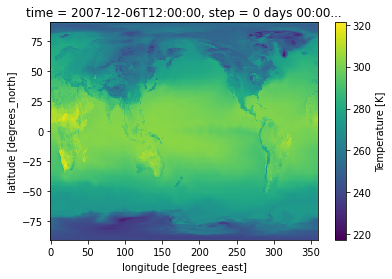

In [10]:
ds.t.plot()

In [12]:
df = ds.to_dataframe()


In [13]:
latitudes = df.index.get_level_values("latitude")
longitudes = df.index.get_level_values("longitude")

In [14]:
longitudes

Float64Index([  0.0,   1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,
                9.0,
              ...
              350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356.0, 357.0, 358.0,
              359.0],
             dtype='float64', name='longitude', length=65160)

In [15]:
map_function = lambda lon: (lon - 360) if (lon > 180) else lon
remapped_longitudes = longitudes.map(map_function)

In [16]:
df["longitude_r"] = remapped_longitudes
df["latitude_r"] = latitudes

In [17]:
df

time   step  surface          valid_time  \
latitude longitude                                                           
 90.0    0.0       2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         1.0       2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         2.0       2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         3.0       2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         4.0       2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
...                                ...    ...      ...                 ...   
-90.0    355.0     2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         356.0     2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         357.0     2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         358.0     2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   
         359.0     2007-12-06 12:00:00 0 days      0.0 2007-12-06 12:00:00   

                          sp       lftx  cape  cin  4lftx         orog  \
latitude longitude                                                       
 90.0    0.0        100810.0  24.299999   0.0  0.0   12.6    -0.400000   
         1.0        100810.0  24.299999   0.0  0.0   12.6    -0.400000   
         2.0        100810.0  24.299999   0.0  0.0   12.6    -0.400000   
         3.0        100810.0  24.299999   0.0  0.0   12.6    -0.400000   
         4.0        100810.0  24.299999   0.0  0.0   12.6    -0.400000   
...                      ...        ...   ...  ...    ...          ...   
-90.0    355.0       68105.0  10.700000   0.0  0.0    0.9  2805.199951   
         356.0       68105.0  10.700000   0.0  0.0    0.9  2805.199951   
         357.0       68105.0  10.700000   0.0  0.0    0.9  2805.199951   
         358.0       68105.0  10.700000   0.0  0.0    0.9  2805.199951   
         359.0       68105.0  10.700000   0.0  0.0    0.9  2805.199951   

                             t   sdwe  lsm  siconc        hpbl  longitude_r  \
latitude longitude                                                            
 90.0    0.0        252.800003  105.0  0.0    0.94  268.200012          0.0   
         1.0        252.800003  105.0  0.0    0.94  268.200012          1.0   
         2.0        252.800003  105.0  0.0    0.94  268.200012          2.0   
         3.0        252.800003  105.0  0.0    0.94  268.200012          3.0   
         4.0        252.800003  105.0  0.0    0.94  268.200012          4.0   
...                        ...    ...  ...     ...         ...          ...   
-90.0    355.0      239.500000  100.0  1.0    0.00  145.100006         -5.0   
         356.0      239.500000  100.0  1.0    0.00  145.100006         -4.0   
         357.0      239.500000  100.0  1.0    0.00  145.100006         -3.0   
         358.0      239.500000  100.0  1.0    0.00  145.100006         -2.0   
         359.0      239.500000  100.0  1.0    0.00  145.100006         -1.0   

                    latitude_r  
latitude longitude              
 90.0    0.0              90.0  
         1.0              90.0  
         2.0              90.0  
         3.0              90.0  
         4.0              90.0  
...                        ...  
-90.0    355.0           -90.0  
         356.0           -90.0  
         357.0           -90.0  
         358.0           -90.0  
         359.0           -90.0  

[65160 rows x 17 columns]

# Imp

In [62]:
# def getData(filename):

#     global mainDF
#     fileAddress = '/pollensource/gfs_archive/' + filename
#     myfile = pygrib.open(fileAddress)

#     # get surface level temperature data
#     grb_temp = myfile.select(shortName='t', typeOfLevel = 'surface')
#     lat = grb_temp[0].latitudes
#     lon = grb_temp[0].longitudes
#     vals = grb_temp[0].values.reshape(lon.shape[0],)
#     date = grb_temp[0].validDate
    
#     df = pd.DataFrame(None, index=range(65160), columns=['date', 'lat', 'lon', 't'])  # range hard-coded for now
#     df['date'] = date
#     df['lat'] = lat
#     df['lon'] = lon
#     df['t'] = vals
    
#     # get 2m level temperature data
#     grb_temp_2m = myfile.select(shortName='2t')
#     vals_2t = grb_temp_2m[0].values.reshape(lon.shape[0],)
#     df['2t'] = vals_2t
    
#     data  = filterAus(df)
    
#     if mainDF is None:
#         data  = filterAus(df)
#         mainDF = data.copy(deep = True)
#     else:
#         frames = [mainDF, data]
#         mainDF = pd.concat(frames)  

#     return mainDF



In [23]:
file_list = ['grib1/2000/2000.01/fnl_20000101_00_00.grib1', 'grib1/2000/2000.01/fnl_20000101_06_00.grib1', 'grib1/2000/2000.01/fnl_20000101_12_00.grib1', 'grib1/2000/2000.01/fnl_20000101_18_00.grib1']
dff2 = downloadData(file_list)

Trying to downloading grib1/2000/2000.01/fnl_20000101_00_00.grib1
downloaded
Trying to downloading grib1/2000/2000.01/fnl_20000101_06_00.grib1
downloaded
Trying to downloading grib1/2000/2000.01/fnl_20000101_12_00.grib1
downloaded
Trying to downloading grib1/2000/2000.01/fnl_20000101_18_00.grib1
downloaded


In [26]:
grouped_t = dff2.groupby(['coord']).agg({'t': ['mean', 'min', 'max']}, {'t_2m': ['mean', 'min', 'max']})
# grouped_t.columns = ['t_mean', 't_min', 't_max']
grouped_t


t              
                 mean    min    max
coord                              
(113.0, -10.0)  302.2  302.2  302.2
(113.0, -11.0)  301.6  301.6  301.6
(113.0, -12.0)  301.5  301.5  301.5
(113.0, -13.0)  301.8  301.8  301.8
(113.0, -14.0)  301.7  301.7  301.7
...               ...    ...    ...
(154.0, -39.0)  291.1  291.1  291.1
(154.0, -40.0)  290.5  290.5  290.5
(154.0, -41.0)  289.8  289.8  289.8
(154.0, -42.0)  289.0  289.0  289.0
(154.0, -43.0)  288.4  288.4  288.4

[1428 rows x 3 columns]

In [181]:
for file in file_list:
    filename = dspath + file
    outfile = save_dir + os.path.basename(filename)
    print('Trying to downloading', file)
    req = requests.get(filename, cookies = ret.cookies, allow_redirects=True)
    if req.status_code != 200:
        print('File not found')
        continue
    else:
        open(outfile, 'wb').write(req.content)
        file_name = save_dir + file.split('/')[-1]
        print('downloaded')

Trying to downloading grib2/2020/2020.01/fnl_20200101_12_00.grib2
downloaded


In [185]:
vars_2000

{'gh': 'Geopotential Height',
 't': 'Temperature',
 'w': 'Vertical velocity',
 'r': 'Relative humidity',
 'absv': 'Absolute vorticity',
 'unknown': 'unknown',
 'u': 'U component of wind',
 'v': 'V component of wind',
 'q': 'Specific humidity',
 'sp': 'Surface pressure',
 'pwat': 'Precipitable water',
 'pres': 'Pressure',
 'orog': 'Orography',
 'msl': 'Mean sea level pressure',
 'pt': 'Potential temperature',
 'tco3': 'Total column ozone',
 'sf': 'Snow Fall water equivalent',
 'lsm': 'Land-sea mask',
 'icec': 'Ice cover (1=ice, 0=no ice)',
 '2t': '2 metre temperature',
 'tcc': 'Total Cloud Cover',
 '10u': '10 metre U wind component',
 '10v': '10 metre V wind component',
 'gpa': 'Geopotential height anomaly'}

In [186]:
vars_2008

{'gh': 'Geopotential Height',
 't': 'Temperature',
 'w': 'Vertical velocity',
 'r': 'Relative humidity',
 'absv': 'Absolute vorticity',
 'o3mr': 'Ozone mixing ratio',
 'clwmr': 'Cloud mixing ratio',
 '5wavh': '5-wave geopotential height',
 'u': 'U component of wind',
 'v': 'V component of wind',
 'q': 'Specific humidity',
 'pres': 'Pressure',
 'vwsh': 'Vertical speed shear',
 'sp': 'Surface pressure',
 'pwat': 'Precipitable water',
 'trpp': 'Tropopause pressure',
 'lftx': 'Surface lifted index',
 'cape': 'Convective available potential energy',
 'cin': 'Convective inhibition',
 '4lftx': 'Best (4-layer) lifted index',
 'orog': 'Orography',
 'prmsl': 'Pressure reduced to MSL',
 'pt': 'Potential temperature',
 'tozne': 'Total ozone',
 'cwat': 'Cloud water',
 'soilw': 'Volumetric soil moisture content',
 'sdwe': 'Water equivalent of accumulated snow depth (deprecated)',
 'lsm': 'Land-sea mask',
 'ci': 'Sea ice area fraction',
 '2t': '2 metre temperature',
 '2sh': '2 metre specific humidity

In [188]:
vars_2020

{'clwmr': 'Cloud mixing ratio',
 'icmr': 'Ice water mixing ratio',
 'rwmr': 'Rain mixing ratio',
 'snmr': 'Snow mixing ratio',
 'grle': 'Graupel (snow pellets)',
 'refc': 'Maximum/Composite radar reflectivity',
 'vis': 'Visibility',
 'u': 'U component of wind',
 'v': 'V component of wind',
 'VRATE': 'Ventilation Rate',
 'gust': 'Wind speed (gust)',
 'gh': 'Geopotential Height',
 't': 'Temperature',
 'absv': 'Absolute vorticity',
 'o3mr': 'Ozone mixing ratio',
 'r': 'Relative humidity',
 'tcc': 'Total Cloud Cover',
 'w': 'Vertical velocity',
 'wz': 'Geometric vertical velocity',
 'hindex': 'Haines Index',
 'mslet': 'MSLP (Eta model reduction)',
 'sp': 'Surface pressure',
 'orog': 'Orography',
 'st': 'Soil Temperature',
 'soilw': 'Volumetric soil moisture content',
 'sdwe': 'Water equivalent of accumulated snow depth (deprecated)',
 'sde': 'Snow depth',
 '2t': '2 metre temperature',
 '2sh': '2 metre specific humidity',
 '2d': '2 metre dewpoint temperature',
 '2r': '2 metre relative humid

# unimp

In [8]:
a = [1,2,3]

In [9]:
b = a[1:] + [3]

In [11]:
b

[2, 3, 3]

In [76]:
p['date'] = pd.to_datetime(p['date']).dt.date

In [146]:
p

,coord,t_mean,t_min,t_max,t_2m_mean,t_2m_min,t_2m_max,date
0,"(113.0, -10.0)",302.8,302.8,302.8,301.575,301.2,302.1,2006-01-01
1,"(113.0, -11.0)",302.8,302.8,302.8,301.125,300.8,301.5,2006-01-01
2,"(113.0, -12.0)",302.8,302.8,302.8,300.650,300.4,300.9,2006-01-01
3,"(113.0, -13.0)",302.5,302.5,302.5,300.100,299.9,300.3,2006-01-01
4,"(113.0, -14.0)",302.2,302.2,302.2,299.575,299.2,299.8,2006-01-01
...,...,...,...,...,...,...,...,...
1423,"(154.0, -39.0)",292.5,292.5,292.5,293.325,291.0,296.3,2006-01-01
1424,"(154.0, -40.0)",291.5,291.5,291.5,292.050,289.6,295.4,2006-01-01
1425,"(154.0, -41.0)",290.6,290.6,290.6,291.025,288.9,294.5,2006-01-01
1426,"(154.0, -42.0)",289.8,289.8,289.8,289.850,287.8,292.9,2006-01-01


In [115]:
grouped_multiple = p.groupby(['coord']).agg({'t': ['mean', 'min', 'max']}, {'t_2m': ['mean', 'min', 'max']})
grouped_multiple.columns = ['t_mean', 't_min', 't_max']
grouped_multiple = grouped_multiple.reset_index()


In [116]:
grouped_multiple2 = p.groupby(['coord']).agg({'t_2m': ['mean', 'min', 'max']}, {'t_2m': ['mean', 'min', 'max']})
grouped_multiple2.columns = ['t_2m_mean', 't_2m_min', 't_2m_max']
grouped_multiple2 = grouped_multiple2.reset_index()
grouped_multiple2

,coord,t_2m_mean,t_2m_min,t_2m_max
0,"(113.0, -10.0)",301.575,301.2,302.1
1,"(113.0, -11.0)",301.125,300.8,301.5
2,"(113.0, -12.0)",300.650,300.4,300.9
3,"(113.0, -13.0)",300.100,299.9,300.3
4,"(113.0, -14.0)",299.575,299.2,299.8
...,...,...,...,...
1423,"(154.0, -39.0)",293.325,291.0,296.3
1424,"(154.0, -40.0)",292.050,289.6,295.4
1425,"(154.0, -41.0)",291.025,288.9,294.5
1426,"(154.0, -42.0)",289.850,287.8,292.9


In [117]:
grouped_multiple = grouped_multiple.merge(grouped_multiple2, how = 'left', on = 'coord')

In [139]:
dateval = p.date.unique()[0]
# grouped_multiple['date'] = grouped_multiple.join(date)

In [140]:
dateval

datetime.date(2006, 1, 1)

In [141]:
grouped_multiple['date'] = dateval

In [142]:
grouped_multiple

,coord,t_mean,t_min,t_max,t_2m_mean,t_2m_min,t_2m_max,date
0,"(113.0, -10.0)",302.8,302.8,302.8,301.575,301.2,302.1,2006-01-01
1,"(113.0, -11.0)",302.8,302.8,302.8,301.125,300.8,301.5,2006-01-01
2,"(113.0, -12.0)",302.8,302.8,302.8,300.650,300.4,300.9,2006-01-01
3,"(113.0, -13.0)",302.5,302.5,302.5,300.100,299.9,300.3,2006-01-01
4,"(113.0, -14.0)",302.2,302.2,302.2,299.575,299.2,299.8,2006-01-01
...,...,...,...,...,...,...,...,...
1423,"(154.0, -39.0)",292.5,292.5,292.5,293.325,291.0,296.3,2006-01-01
1424,"(154.0, -40.0)",291.5,291.5,291.5,292.050,289.6,295.4,2006-01-01
1425,"(154.0, -41.0)",290.6,290.6,290.6,291.025,288.9,294.5,2006-01-01
1426,"(154.0, -42.0)",289.8,289.8,289.8,289.850,287.8,292.9,2006-01-01


In [42]:
pp.iloc[0,3]

'(113.0, -10.0)'

In [51]:
mainDF['coord'] = list(zip(mainDF.lat, mainDF.lon))

In [39]:
dd.groupby(['coord']).min()

,date,t,t_2m
coord,,,
"(113.0, -10.0)",2000-01-01,302.2,300.6
"(113.0, -11.0)",2000-01-01,301.6,300.3
"(113.0, -12.0)",2000-01-01,301.5,300.3
"(113.0, -13.0)",2000-01-01,301.8,300.5
"(113.0, -14.0)",2000-01-01,301.7,300.0
...,...,...,...
"(154.0, -39.0)",2000-01-01,291.1,290.5
"(154.0, -40.0)",2000-01-01,290.5,289.5
"(154.0, -41.0)",2000-01-01,289.8,288.3


In [41]:
dd.coord.nunique()

1428

In [19]:
lat_filter = (df["latitude_r"] >= min_lat) & (df["latitude_r"] <= max_lat)
lon_filter = (df["longitude_r"] >= min_lon) & (df["longitude_r"] <= max_lon)

In [20]:
df = df.loc[lat_filter & lon_filter]

In [21]:
df.to_csv('archive_data.csv', index=False)

In [34]:
rain = xarray.open_dataset(selected_file.value, engine="cfgrib", filter_by_keys={'shortName': 'apcp'})

In [35]:
rain

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.7
    history:      2022-05-30T09:05 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

In [3]:
filename = '/pollensource/gfs_archive/fnl_20071206_12_00.grib2'
myfile = pygrib.open(filename)


In [4]:
def grb_to_grid(grb_obj):
    """Takes a single grb object containing multiple
    levels. Assumes same time, pressure levels. Compiles to a cube"""
    n_levels = len(grb_obj)
    levels = np.array([grb_element['level'] for grb_element in grb_obj])
    indexes = np.argsort(levels)[::-1] # highest pressure first
    cube = np.zeros([n_levels, grb_obj[0].values.shape[0], grb_obj[1].values.shape[1]])
    for i in range(n_levels):
        cube[i,:,:] = grb_obj[indexes[i]].values
    cube_dict = {'data' : cube, 'units' : grb_obj[0]['units'],
                 'levels' : levels[indexes]}
    return cube_dict

In [7]:
# grb = myfile.select(name='Geopotential Height')
# grb_cube=grb_to_grid(grb)
grb_r = myfile.select(shortName='r', typeOfLevel = 'atmosphereSingleLayer')
# grb_cube_temp=grb_to_grid(grb_v)

In [8]:
grb_r

[229:Relative humidity:% (instant):regular_ll:atmosphereSingleLayer:level 0 considered as a single layer:fcst time 0 hrs:from 200712061200]

In [24]:
print(grb_cube_temp['units'])
print(grb_cube_temp['levels'])

m s**-1
[9950 3658 2743 1829 1000  975  950  925  900  850  800  750  700  650
  600  550  500  450  400  350  300  250  200  150  100   70   50   30
   30   20   10    0    0]


In [7]:
grb_v = myfile.select(shortName='v', level = 0, typeOfLevel = 'maxWind')
grb_r= myfile.select(shortName='r')
grb_p = myfile.select(shortName='msl')

In [8]:
grb_r

[74:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 1000:fcst time 0 hrs:from 200001011200,
 75:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 975:fcst time 0 hrs:from 200001011200,
 76:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 950:fcst time 0 hrs:from 200001011200,
 77:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 925:fcst time 0 hrs:from 200001011200,
 78:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 900:fcst time 0 hrs:from 200001011200,
 79:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 850:fcst time 0 hrs:from 200001011200,
 80:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 800:fcst time 0 hrs:from 200001011200,
 81:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 750:fcst time 0 hrs:from 200001011200,
 82:Relative humidity:% (instant):regular_ll:isobaricInhPa:level 700:fcst time 0 hrs:from 200001011200,
 83:Relative humidity:% (instant):regular_ll:isobaricInhPa:leve

In [39]:
grb_v10

[243:10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10:fcst time 0 hrs:from 200001011200]

In [23]:
f = plt.figure(figsize=[12,10])
m = Basemap(llcrnrlon = -130,llcrnrlat = 20, urcrnrlon = -70,
           urcrnrlat = 52 , projection = 'mill', area_thresh =10000 ,
           resolution='l')
x, y = m(lons, lats)

my_mesh = m.pcolormesh(x, y, grb_cube_temp['data'][10], vmax =  .05)
my_coast = m.drawcoastlines(linewidth=1.25)
my_states = m.drawstates()
my_p = m.drawparallels(np.arange(20,80,4),labels=[1,1,0,0])
my_m = m.drawmeridians(np.arange(-140,-60,4),labels=[0,0,0,1])
plt.colorbar(label='K')

NameError: name 'lons' is not defined

<Figure size 864x720 with 0 Axes>

In [32]:
print(grb_temp[10])


37:Temperature:K (instant):regular_ll:isobaricInhPa:level 600:fcst time 0 hrs:from 200001010000


In [33]:
levels = np.array([grb_element['level'] for grb_element in grb_temp])


In [34]:
print(np.argsort(levels)[::-1])


[32 29 28 27  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 26 24 25 35 34 30 31 33]


In [36]:
for grb in grb_temp:
    print(grb)

27:Temperature:K (instant):regular_ll:isobaricInhPa:level 1000:fcst time 0 hrs:from 200001010000
28:Temperature:K (instant):regular_ll:isobaricInhPa:level 975:fcst time 0 hrs:from 200001010000
29:Temperature:K (instant):regular_ll:isobaricInhPa:level 950:fcst time 0 hrs:from 200001010000
30:Temperature:K (instant):regular_ll:isobaricInhPa:level 925:fcst time 0 hrs:from 200001010000
31:Temperature:K (instant):regular_ll:isobaricInhPa:level 900:fcst time 0 hrs:from 200001010000
32:Temperature:K (instant):regular_ll:isobaricInhPa:level 850:fcst time 0 hrs:from 200001010000
33:Temperature:K (instant):regular_ll:isobaricInhPa:level 800:fcst time 0 hrs:from 200001010000
34:Temperature:K (instant):regular_ll:isobaricInhPa:level 750:fcst time 0 hrs:from 200001010000
35:Temperature:K (instant):regular_ll:isobaricInhPa:level 700:fcst time 0 hrs:from 200001010000
36:Temperature:K (instant):regular_ll:isobaricInhPa:level 650:fcst time 0 hrs:from 200001010000
37:Temperature:K (instant):regular_ll:i

In [37]:
print(grb.keys())


['globalDomain', 'GRIBEditionNumber', 'eps', 'offsetSection0', 'section0Length', 'totalLength', 'editionNumber', 'WMO', 'productionStatusOfProcessedData', 'section1Length', 'wrongPadding', 'table2Version', 'centre', 'centreDescription', 'generatingProcessIdentifier', 'gridDefinition', 'indicatorOfParameter', 'parameterName', 'parameterUnits', 'indicatorOfTypeOfLevel', 'pressureUnits', 'typeOfLevelECMF', 'typeOfLevel', 'topLevel', 'bottomLevel', 'levels', 'yearOfCentury', 'month', 'day', 'hour', 'minute', 'second', 'unitOfTimeRange', 'P1', 'P2', 'timeRangeIndicator', 'numberIncludedInAverage', 'numberMissingFromAveragesOrAccumulations', 'centuryOfReferenceTimeOfData', 'subCentre', 'paramIdECMF', 'paramId', 'cfNameECMF', 'cfName', 'cfVarNameECMF', 'cfVarName', 'unitsECMF', 'units', 'nameECMF', 'name', 'decimalScaleFactor', 'setLocalDefinition', 'optimizeScaleFactor', 'dataDate', 'year', 'dataTime', 'julianDay', 'stepUnits', 'stepType', 'stepRange', 'startStep', 'endStep', 'marsParam', 'v

In [53]:
myfile.rewind() # rewind the iterator
from datetime import datetime
date_valid = datetime(2000,1,1,0)
t2mens = []
for grb in myfile:
    if grb.parameterName == 'T Temperature K' and grb.level == 2: 
        t2mens.append(grb.values)
t2mens = np.array(t2mens)
print(t2mens.shape, t2mens.min(), t2mens.max())
lats, lons = grb.latlons()  # get the lats and lons for the grid.
print('min/max lat and lon',lats.min(), lats.max(), lons.min(), lons.max())

(1, 181, 360) 223.4 315.90000000000003
min/max lat and lon -90.0 90.0 0.0 359.0


In [54]:
myfile.rewind() # rewind the iterator

for grb in myfile:
    if grb.parameterName[0] == 'T':
        print(grb.level)

1000
975
950
925
900
850
800
750
700
650
600
550
500
450
400
350
300
250
200
150
100
70
50
30
20
10
30
1829
2743
3658
0
0
9950
0
0
0
10
2
0


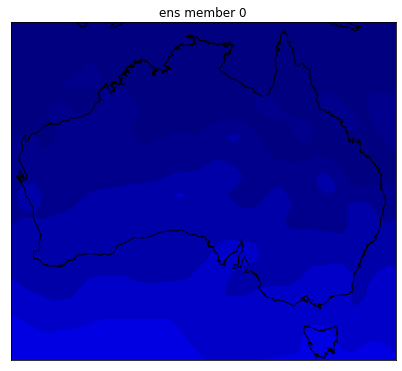

In [52]:
fig = plt.figure(figsize=(40,80))
# m = Basemap(projection='lcc',lon_0=112.500,lat_0=-43.835,width=8.e6,height=8.e6)
m = Basemap(projection='mill',llcrnrlon = 112.500,llcrnrlat = -43.835, urcrnrlon = 154.688,
           urcrnrlat = -9.796 ,area_thresh =10000 ,
           resolution='l')
x,y = m(lons,lats)
for nens in range(0,1):
    ax = plt.subplot(10,5,nens+1)
    m.drawcoastlines()
    cs = m.contourf(x,y,t2mens[nens],np.linspace(230,300,41),cmap=plt.cm.jet,extend='both')
    t = plt.title('ens member %s' % nens)

In [56]:
map_function = lambda lon: (lon - 360) if (lon > 180) else lon
remapped_longitudes = longitudes.map(map_function)

1

In [115]:
grb_temp2 = myfile.select(name='Temperature', level=lambda l: l < 10 and l >= 0)

In [117]:
for grb in grb_temp2:
    print(grb.typeOfLevel, grb.)

tropopause t
maxWind t
surface t
depthBelowLandLayer t


In [113]:
levels = np.array([grb_element['level'] for grb_element in grb_temp2])

In [114]:
print(np.argsort(levels)[::-1])


[ 0  1  5  2  3 10  4  9  8  7  6]


In [18]:
myfile.rewind() # rewind the iterator
vars = dict()
for grb_element in myfile:
    if grb_element['shortName'] not in vars:
         vars[grb_element['shortName']] = grb_element['name']
        # print()

print(vars)

{'gh': 'Geopotential Height', 't': 'Temperature', 'w': 'Vertical velocity', 'r': 'Relative humidity', 'absv': 'Absolute vorticity', 'unknown': 'unknown', 'u': 'U component of wind', 'v': 'V component of wind', 'q': 'Specific humidity', 'sp': 'Surface pressure', 'pwat': 'Precipitable water', 'pres': 'Pressure', 'orog': 'Orography', 'msl': 'Mean sea level pressure', 'pt': 'Potential temperature', 'tco3': 'Total column ozone', 'sf': 'Snow Fall water equivalent', 'lsm': 'Land-sea mask', 'icec': 'Ice cover (1=ice, 0=no ice)', '2t': '2 metre temperature', 'tcc': 'Total Cloud Cover', '10u': '10 metre U wind component', '10v': '10 metre V wind component', 'gpa': 'Geopotential height anomaly'}


In [42]:
grb1 = myfile.select(shortName='unknown')

In [43]:
grb1

[121:154:154 (instant):regular_ll:isobaricInhPa:level 100:fcst time 0 hrs:from 200001010000,
 122:154:154 (instant):regular_ll:isobaricInhPa:level 70:fcst time 0 hrs:from 200001010000,
 123:154:154 (instant):regular_ll:isobaricInhPa:level 50:fcst time 0 hrs:from 200001010000,
 124:154:154 (instant):regular_ll:isobaricInhPa:level 30:fcst time 0 hrs:from 200001010000,
 125:154:154 (instant):regular_ll:isobaricInhPa:level 20:fcst time 0 hrs:from 200001010000,
 126:154:154 (instant):regular_ll:isobaricInhPa:level 10:fcst time 0 hrs:from 200001010000,
 127:222:222 (instant):regular_ll:isobaricInhPa:level 500:fcst time 0 hrs:from 200001010000,
 200:136:136 (instant):regular_ll:tropopause:level 0:fcst time 0 hrs:from 200001010000,
 201:131:131 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 200001010000,
 202:157:157 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 200001010000,
 203:156:156 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 200001010000,
 204:132:13

In [182]:
filename2 = '/pollensource/gfs_archive/fnl_20200101_12_00.grib2'
myfile2 = pygrib.open(filename2)

In [183]:
filename2 = '/pollensource/gfs_archive/fnl_20200101_12_00.grib2'
myfile2 = pygrib.open(filename2)

vars_2020 = dict()
for grb_element in myfile2:
    if grb_element['shortName'] not in vars_2020:
        vars_2020[grb_element['shortName']] = grb_element['name']

In [176]:
vars_2008

{'gh': 'Geopotential Height',
 't': 'Temperature',
 'w': 'Vertical velocity',
 'r': 'Relative humidity',
 'absv': 'Absolute vorticity',
 'o3mr': 'Ozone mixing ratio',
 'clwmr': 'Cloud mixing ratio',
 '5wavh': '5-wave geopotential height',
 'u': 'U component of wind',
 'v': 'V component of wind',
 'q': 'Specific humidity',
 'pres': 'Pressure',
 'vwsh': 'Vertical speed shear',
 'sp': 'Surface pressure',
 'pwat': 'Precipitable water',
 'trpp': 'Tropopause pressure',
 'lftx': 'Surface lifted index',
 'cape': 'Convective available potential energy',
 'cin': 'Convective inhibition',
 '4lftx': 'Best (4-layer) lifted index',
 'orog': 'Orography',
 'prmsl': 'Pressure reduced to MSL',
 'pt': 'Potential temperature',
 'tozne': 'Total ozone',
 'cwat': 'Cloud water',
 'soilw': 'Volumetric soil moisture content',
 'sdwe': 'Water equivalent of accumulated snow depth (deprecated)',
 'lsm': 'Land-sea mask',
 'ci': 'Sea ice area fraction',
 '2t': '2 metre temperature',
 '2sh': '2 metre specific humidity

In [179]:
vars_2000

{'gh': 'Geopotential Height',
 't': 'Temperature',
 'w': 'Vertical velocity',
 'r': 'Relative humidity',
 'absv': 'Absolute vorticity',
 'unknown': 'unknown',
 'u': 'U component of wind',
 'v': 'V component of wind',
 'q': 'Specific humidity',
 'sp': 'Surface pressure',
 'pwat': 'Precipitable water',
 'pres': 'Pressure',
 'orog': 'Orography',
 'msl': 'Mean sea level pressure',
 'pt': 'Potential temperature',
 'tco3': 'Total column ozone',
 'sf': 'Snow Fall water equivalent',
 'lsm': 'Land-sea mask',
 'icec': 'Ice cover (1=ice, 0=no ice)',
 '2t': '2 metre temperature',
 'tcc': 'Total Cloud Cover',
 '10u': '10 metre U wind component',
 '10v': '10 metre V wind component',
 'gpa': 'Geopotential height anomaly'}

In [29]:
grb_temp2m = myfile.select(shortName='2t')


In [34]:
for g in grb_temp2m:
    coord = g.latlons()

In [35]:
coord

(array([[ 90.,  90.,  90., ...,  90.,  90.,  90.],
        [ 89.,  89.,  89., ...,  89.,  89.,  89.],
        [ 88.,  88.,  88., ...,  88.,  88.,  88.],
        ...,
        [-88., -88., -88., ..., -88., -88., -88.],
        [-89., -89., -89., ..., -89., -89., -89.],
        [-90., -90., -90., ..., -90., -90., -90.]]),
 array([[  0.,   1.,   2., ..., 357., 358., 359.],
        [  0.,   1.,   2., ..., 357., 358., 359.],
        [  0.,   1.,   2., ..., 357., 358., 359.],
        ...,
        [  0.,   1.,   2., ..., 357., 358., 359.],
        [  0.,   1.,   2., ..., 357., 358., 359.],
        [  0.,   1.,   2., ..., 357., 358., 359.]]))

In [ ]:
['globalDomain', 'GRIBEditionNumber', 'eps', 'offsetSection0', 'section0Length', 'totalLength', 'editionNumber', 'WMO', 'productionStatusOfProcessedData', 'section1Length', 'wrongPadding', 'table2Version', 'centre', 'centreDescription', 'generatingProcessIdentifier', 'gridDefinition', 'indicatorOfParameter', 'parameterName', 'parameterUnits', 'indicatorOfTypeOfLevel', 'pressureUnits', 'typeOfLevelECMF', 'typeOfLevel', 'topLevel', 'bottomLevel', 'levels', 'yearOfCentury', 'month', 'day', 'hour', 'minute', 'second', 'unitOfTimeRange', 'P1', 'P2', 'timeRangeIndicator', 'numberIncludedInAverage', 'numberMissingFromAveragesOrAccumulations', 'centuryOfReferenceTimeOfData', 'subCentre', 'paramIdECMF', 'paramId', 'cfNameECMF', 'cfName', 'cfVarNameECMF', 'cfVarName', 'unitsECMF', 'units', 'nameECMF', 'name', 'decimalScaleFactor', 'setLocalDefinition', 'optimizeScaleFactor', 'dataDate', 'year', 'dataTime', 'julianDay', 'stepUnits', 'stepType', 'stepRange', 'startStep', 'endStep', 'marsParam', 'validityDate', 'validityTime', 'deleteLocalDefinition', 'localUsePresent', 'shortNameECMF', 'shortName', 'ifsParam', 'stepTypeForConversion', 'md5Section1', 'md5Product', 'gridDescriptionSectionPresent', 'bitmapPresent', 'angleSubdivisions', 'section2Length', 'radius', 'numberOfVerticalCoordinateValues', 'neitherPresent', 'pvlLocation', 'dataRepresentationType', 'gridDefinitionDescription', 'gridDefinitionTemplateNumber', 'Ni', 'Nj', 'latitudeOfFirstGridPoint', 'latitudeOfFirstGridPointInDegrees', 'longitudeOfFirstGridPoint', 'longitudeOfFirstGridPointInDegrees', 'resolutionAndComponentFlags', 'ijDirectionIncrementGiven', 'earthIsOblate', 'resolutionAndComponentFlags3', 'resolutionAndComponentFlags4', 'uvRelativeToGrid', 'resolutionAndComponentFlags6', 'resolutionAndComponentFlags7', 'resolutionAndComponentFlags8', 'latitudeOfLastGridPoint', 'latitudeOfLastGridPointInDegrees', 'longitudeOfLastGridPoint', 'longitudeOfLastGridPointInDegrees', 'iDirectionIncrement', 'jDirectionIncrement', 'scanningMode', 'iScansNegatively', 'jScansPositively', 'jPointsAreConsecutive', 'alternativeRowScanning', 'iScansPositively', 'scanningMode4', 'scanningMode5', 'scanningMode6', 'scanningMode7', 'scanningMode8', 'jDirectionIncrementInDegrees', 'iDirectionIncrementInDegrees', 'numberOfDataPoints', 'numberOfValues', 'latLonValues', 'latitudes', 'longitudes', 'distinctLatitudes', 'distinctLongitudes', 'zeros', 'PVPresent', 'PLPresent', 'deletePV', 'md5Section2', 'lengthOfHeaders', 'md5Headers', 'missingValue', 'section3Length', 'numberOfUnusedBitsAtEndOfSection3', 'tableReference', 'md5Section3', 'section4Length', 'halfByte', 'dataFlag', 'binaryScaleFactor', 'referenceValue', 'referenceValueError', 'sphericalHarmonics', 'complexPacking', 'integerPointValues', 'additionalFlagPresent', 'orderOfSPD', 'boustrophedonic', 'hideThis', 'packingType', 'bitsPerValue', 'constantFieldHalfByte', 'bitMapIndicator', 'codedValues', 'values', 'numberOfCodedValues', 'packingError', 'unpackedError', 'maximum', 'minimum', 'average', 'numberOfMissing', 'standardDeviation', 'skewness', 'kurtosis', 'isConstant', 'dataLength', 'changeDecimalPrecision', 'decimalPrecision', 'bitsPerValueAndRepack', 'scaleValuesBy', 'offsetValuesBy', 'gridType', 'getNumberOfValues', 'md5Section4', 'section5Length', 'analDate', 'validDate']

In [30]:
filename3 = '/pollensource/gfs_archive/fnl_20000131_18_00.grib1'
myfile3 = pygrib.open(filename3)


In [31]:
grb_temp3 = myfile3.select(shortName='t')

In [36]:
# data = []
for g in grb_temp3:
    if g.level == 0 and g.typeOfLevel == 'surface':
        # data= g.values
        # print(g.longitudes)
        print(g.deleteLocalDefinition)

0


In [43]:
data.shape

(181, 360)

SyntaxError: unexpected EOF while parsing (3639794199.py, line 1)

In [130]:
grb_temp = myfile3.select(shortName='t', typeOfLevel = 'surface')

In [131]:
lat, lon = grb_temp[0].latlons()
vals = grb_temp[0].values

In [132]:
lon.shape

(181, 360)

In [133]:
lat

array([[ 90.,  90.,  90., ...,  90.,  90.,  90.],
       [ 89.,  89.,  89., ...,  89.,  89.,  89.],
       [ 88.,  88.,  88., ...,  88.,  88.,  88.],
       ...,
       [-88., -88., -88., ..., -88., -88., -88.],
       [-89., -89., -89., ..., -89., -89., -89.],
       [-90., -90., -90., ..., -90., -90., -90.]])

In [134]:
lon

array([[  0.,   1.,   2., ..., 357., 358., 359.],
       [  0.,   1.,   2., ..., 357., 358., 359.],
       [  0.,   1.,   2., ..., 357., 358., 359.],
       ...,
       [  0.,   1.,   2., ..., 357., 358., 359.],
       [  0.,   1.,   2., ..., 357., 358., 359.],
       [  0.,   1.,   2., ..., 357., 358., 359.]])

In [135]:
vals

array([[273.1, 273.1, 273.1, ..., 273.1, 273.1, 273.1],
       [273.1, 273.1, 273.1, ..., 273.1, 273.1, 273.1],
       [273.1, 273.1, 273.1, ..., 273.1, 273.1, 273.1],
       ...,
       [218.2, 218.1, 217.9, ..., 218.6, 218.5, 218.4],
       [222.9, 222.9, 222.8, ..., 223. , 223. , 222.9],
       [225.9, 225.9, 225.9, ..., 225.9, 225.9, 225.9]])

In [136]:
lat.reshape(65160,)

array([ 90.,  90.,  90., ..., -90., -90., -90.])

In [137]:
lon.reshape(65160,)

array([  0.,   1.,   2., ..., 357., 358., 359.])

In [138]:
vals.reshape(65160,)

array([273.1, 273.1, 273.1, ..., 225.9, 225.9, 225.9])

In [139]:
d = grb_temp[0].validDate

In [140]:
df = pd.DataFrame(None, index=range(65160), columns=list('ABC'))
df

,A,B,C
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
65155,NaN,NaN,NaN
65156,NaN,NaN,NaN
65157,NaN,NaN,NaN
65158,NaN,NaN,NaN


In [141]:
df.columns = ['lat', 'lon', 'date']
df['lat'] = lat.reshape(65160,)
df['lon'] = lon.reshape(65160,)
df['date'] = d

In [142]:
df

,lat,lon,date
0,90.0,0.0,2006-07-01 06:00:00
1,90.0,1.0,2006-07-01 06:00:00
2,90.0,2.0,2006-07-01 06:00:00
3,90.0,3.0,2006-07-01 06:00:00
4,90.0,4.0,2006-07-01 06:00:00
...,...,...,...
65155,-90.0,355.0,2006-07-01 06:00:00
65156,-90.0,356.0,2006-07-01 06:00:00
65157,-90.0,357.0,2006-07-01 06:00:00
65158,-90.0,358.0,2006-07-01 06:00:00


In [143]:
df2 = filterAus(df)

In [144]:
df2

,lat,lon,date
0,-10.0,113.0,2006-07-01 06:00:00
1,-10.0,114.0,2006-07-01 06:00:00
2,-10.0,115.0,2006-07-01 06:00:00
3,-10.0,116.0,2006-07-01 06:00:00
4,-10.0,117.0,2006-07-01 06:00:00
...,...,...,...
1423,-43.0,150.0,2006-07-01 06:00:00
1424,-43.0,151.0,2006-07-01 06:00:00
1425,-43.0,152.0,2006-07-01 06:00:00
1426,-43.0,153.0,2006-07-01 06:00:00


In [109]:
mainDF = None

In [113]:
if mainDF is None:
    mainDF = df.copy(deep = True)
else:
    print('Hey')

Hey


In [30]:
pp

,date,t,t_2m,coord
0,2000-01-01 00:00:00,302.2,300.6,"(113.0, -10.0)"
1,2000-01-01 00:00:00,302.2,300.8,"(114.0, -10.0)"
2,2000-01-01 00:00:00,302.2,301.3,"(115.0, -10.0)"
3,2000-01-01 00:00:00,302.4,301.9,"(116.0, -10.0)"
4,2000-01-01 00:00:00,302.5,302.3,"(117.0, -10.0)"
...,...,...,...,...
1423,2000-01-01 18:00:00,288.9,287.1,"(150.0, -43.0)"
1424,2000-01-01 18:00:00,288.5,287.0,"(151.0, -43.0)"
1425,2000-01-01 18:00:00,288.2,286.9,"(152.0, -43.0)"
1426,2000-01-01 18:00:00,288.3,287.3,"(153.0, -43.0)"


coord
(113.0, -10.0)    302.2
(113.0, -11.0)    301.6
(113.0, -12.0)    301.5
(113.0, -13.0)    301.8
(113.0, -14.0)    301.7
                  ...  
(154.0, -39.0)    291.1
(154.0, -40.0)    290.5
(154.0, -41.0)    289.8
(154.0, -42.0)    289.0
(154.0, -43.0)    288.4
Name: t, Length: 1428, dtype: float64

In [ ]:
filename2 = '/pollensource/gfs_archive/fnl_20200101_12_00.grib2'
myfile2 = pygrib.open(filename2)

vars_2020 = dict()
for grb_element in myfile2:
    if grb_element['shortName'] not in vars_2020:
        vars_2020[grb_element['shortName']] = grb_element['name']